## Bag of words 

In [2]:
import numpy as np
import pandas as pd
from typing import List, Any
import itertools
import gensim

from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as m

from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap

processed_data_path = Path('../data/processed/tokenized_std_socialmedia_relevant_cols.csv')
word2vec_path = Path('../data/raw/GoogleNews-vectors-negative300.bin.gz')
df = pd.read_csv(processed_data_path)
df['tokens'] = df['tokens'].apply(
    lambda x: x.replace('"', '') \
               .replace("'", "") \
               .strip('[]') \
               .split(', ')
)
SEED = 10

In [3]:
for i in df['tokens']:
    print(i)

['just', 'happened', 'a', 'terrible', 'car', 'crash']
['our', 'deeds', 'are', 'the', 'reason', 'of', 'this', 'earthquake', 'may', 'allah', 'forgive', 'us', 'all']
['heard', 'about', 'earthquake', 'is', 'different', 'cities', 'stay', 'safe', 'everyone']
['there', 'is', 'a', 'forest', 'fire', 'at', 'spot', 'pond', 'geese', 'are', 'fleeing', 'across', 'the', 'street', 'i', 'cannot', 'save', 'them', 'all']
['forest', 'fire', 'near', 'la', 'ronge', 'sask', 'canada']
['all', 'residents', 'asked', 'to', 'shelter', 'in', 'place', 'are', 'being', 'notified', 'by', 'officers', 'no', 'other', 'evacuation', 'or', 'shelter', 'in', 'place', 'orders', 'are', 'expected']
['13000', 'people', 'receive', 'wildfires', 'evacuation', 'orders', 'in', 'california']
['just', 'got', 'sent', 'this', 'photo', 'from', 'ruby', 'alaska', 'as', 'smoke', 'from', 'wildfires', 'pours', 'into', 'a', 'school']
['rockyfire', 'update', 'california', 'hwy', '20', 'closed', 'in', 'both', 'directions', 'due', 'to', 'lake', 'co

Building bag-of-words with Word2Vec

In [4]:
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [5]:
def get_average_word2vec(
    tokens_list: List,
    vector: List,
    generate_missing: bool = False,
    k: int = 300
) -> float:
    '''Method to calculate the semantic distance between the words
    
    :param tokens_list: List of tokens
    :param vector: Vector from word2vec trained model
    :type tokens_list: List
    :type vector: List
    :return: average semantic distance between words
    :rtype: float
    '''
    if len(tokens_list) < 1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [
            vector[word] if word in vector else np.random.rand(k)
            for word in tokens_list
        ]
    else:
        vectorized = [
            vector[word] if word in vector else np.zeros(k)
            for word in tokens_list
        ]
    length = len(vectorized)
    vectorized_sum = np.sum(vectorized, axis=0)
    vectorized_average_list = np.divide(vectorized_sum, length)
    
    return vectorized_average_list

In [6]:
def get_word2vec_embeddings(vectors: List, df: Any, generate_missing=False):
    '''Building of the training file containing
    the semantic relation between the words.

    :param vectors: Vector from word2vec trained model
    :param df: Cleaned data
    :type vectors: List[Any]
    :type df: Any
    :return: word2vec embedded tokens
    :rtype: List[Any]
    '''
    embeddings = df['tokens'].apply(
        lambda x: get_average_word2vec(x, vectors, generate_missing=generate_missing)
    )
    
    return list(embeddings)

In [7]:
embeddings = get_word2vec_embeddings(word2vec, df)

list_labels = df['class_label'].tolist()


X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(
    embeddings,
    list_labels,
    test_size=0.2,
    random_state=SEED
)

Visualizing the vocabulary

In [8]:
def lsa(data, labels, plot=False, savepath='../imgs/lsa_plot.jpg'):
    lsa_model = TruncatedSVD(n_components=2)
    lsa_model.fit(data)
    lsa_scores = lsa_model.transform(data)
    color_mapper = {label: index for index, label in enumerate(set(labels))}
    color_column = [color_mapper[label] for label in labels]
    colors = ['orange', 'blue', 'blue']
    if plot:
        fig = plt.figure(figsize=(10,10))
        plt.scatter(
            lsa_scores[:,0],
            lsa_scores[:,1],
            s=8,
            alpha=0.8,
            c=labels,
            cmap=ListedColormap(colors=colors)
        )
        red_patch = Patch(color='orange', label='irrelevant')
        green_patch = Patch(color='blue', label='disaster')
        plt.legend(handles=[red_patch, green_patch], prop={'size':20})
        plt.show()
        plt.savefig(savepath)

In [9]:
lsa(embeddings, list_labels, plot=True)

<Figure size 432x288 with 0 Axes>

Training the classifier

In [10]:
clf_w2v = LogisticRegression(
    C=30,
    class_weight='balanced',
    solver='newton-cg',
    multi_class='multinomial',
    n_jobs=-1,
    random_state=SEED
)
clf_w2v.fit(X_train_word2vec, y_train_word2vec)
y_predicted_word2vec = clf_w2v.predict(X_test_word2vec)

Evaluating the classifier

Métricas de avaliação:

$$Precision = \frac{TP}{TP + FP}$$
$$Recall = \frac{TP}{TP + FN}$$
$$F_1 = 2 \cdot \frac{Precision \cdot Recall}{Precision + Recall}$$
$$Accuracy = \frac{TP + TF}{Total}$$

In [11]:
def get_metrics(y_test, y_predicted):
    precision = m.precision_score(
        y_test,
        y_predicted,
        pos_label=None,
        average='weighted'
    )
    recall = m.recall_score(
        y_test,
        y_predicted,
        pos_label=None,
        average='weighted'
    )
    f1 = m.f1_score(
        y_test,
        y_predicted,
        pos_label=None,
        average='weighted'
    )
    acc = m.accuracy_score(y_test, y_predicted)
    
    return acc, precision, recall, f1

In [12]:
acc, precision, recall, f1 = get_metrics(y_test_word2vec, y_predicted_word2vec)
print(f'accuracy = {acc:.3f}, precision = {precision:.3f}, recall = {recall:.3f}, f1 = {f1:.3f}')

accuracy = 0.795, precision = 0.797, recall = 0.795, f1 = 0.796


Creating a confusion matrix

In [13]:
def plot_confusion_matrix(
    cm,
    classes,
    normalize=False,
    title='Confusion Matrix',
    cmap=plt.cm.winter
):
    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            format(cm[i, j], fmt),
            horizontalalignment='center',
            color='white' if cm[i, j] < thresh else 'black',
            fontsize=40
        )
        plt.tight_layout()
        plt.ylabel('True label', fontsize=30)
        plt.xlabel('Predicted label', fontsize=30)
    return plt

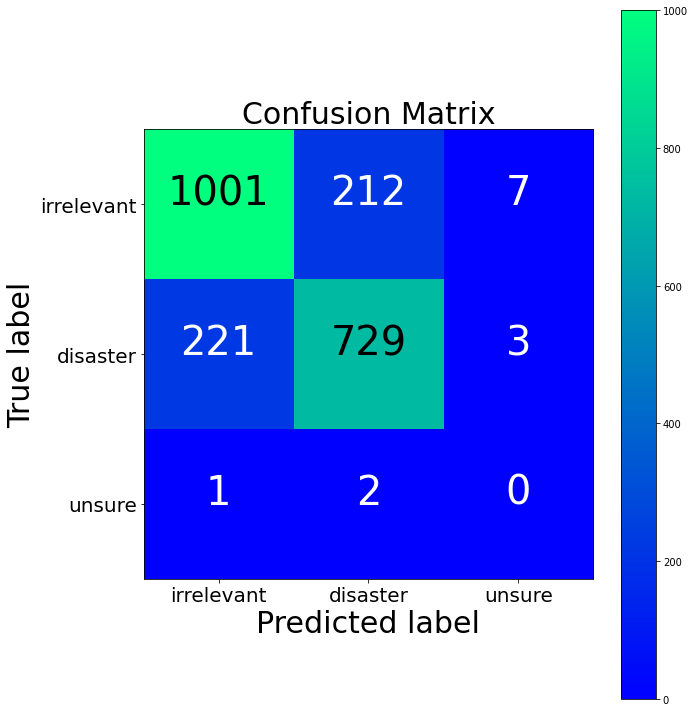

Word2Vec Confusion Matrix
[[1001  212    7]
 [ 221  729    3]
 [   1    2    0]]


In [14]:
cm = m.confusion_matrix(y_test_word2vec, y_predicted_word2vec)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(
    cm,
    classes=['irrelevant', 'disaster', 'unsure'],
    normalize=False,
    title='Confusion Matrix'
)
plt.show()
print('Word2Vec Confusion Matrix')
print(cm)

Method to identifying the most important features in the desicion making

In [15]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v: k for k, v in vectorizer.vocabulary_.items()}
    # Loop for each class
    classes = {}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [
            (el, index_to_word[i])
            for i, el in enumerate(model.coef_[class_index])
        ]
        sorted_coeff = sorted(
            word_importances,
            key=lambda x: x[0], reverse=True
        )
        tops = sorted(sorted_coeff[:n], key=lambda x: x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {'tops': tops, 'bottom': bottom}
    return classes

In [16]:
importance = get_most_important_features(tfidf_vectorizer, clf, 10)

Method to plot the most important features

In [17]:
def plot_important_words(
    top_scores,
    top_words,
    bottom_scores,
    bottom_words,
    name
):
    y_pos = np.arange(len(top_words))
    top_pairs = sorted(
        [(a,b) for a,b in zip(top_words, top_scores)],
        key=lambda x: x[1]
    )
    bottom_pairs = sorted(
        [(a,b) for a,b in zip(bottom_words, bottom_scores)],
        key=lambda x: x[1], reverse=True
    )
    top_words_ = [a[0] for a in top_pairs]
    top_scores_ = [a[1] for a in top_pairs]
    bottom_words_ = [a[0] for a in bottom_pairs]
    bottom_scores_ = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 10))
    plt.subplot(121)
    plt.barh(
        y_pos,
        bottom_scores_,
        align='center',
        alpha=0.5
    )
    plt.title('irrelevant', fontsize=16)
    plt.yticks(y_pos, bottom_words_, fontsize=12)
    plt.suptitle('Key words', fontsize=14)
    plt.xlabel('Importance', fontsize=16)
    
    plt.subplot(122)
    plt.barh(
        y_pos,
        top_scores_,
        align='center',
        alpha=0.5
    )
    plt.title('disaster', fontsize=16)
    plt.yticks(y_pos, top_words_, fontsize=12)
    plt.suptitle('Importance', fontsize=16)
    plt.subplots_adjust(wspace=0.8)
    plt.show()

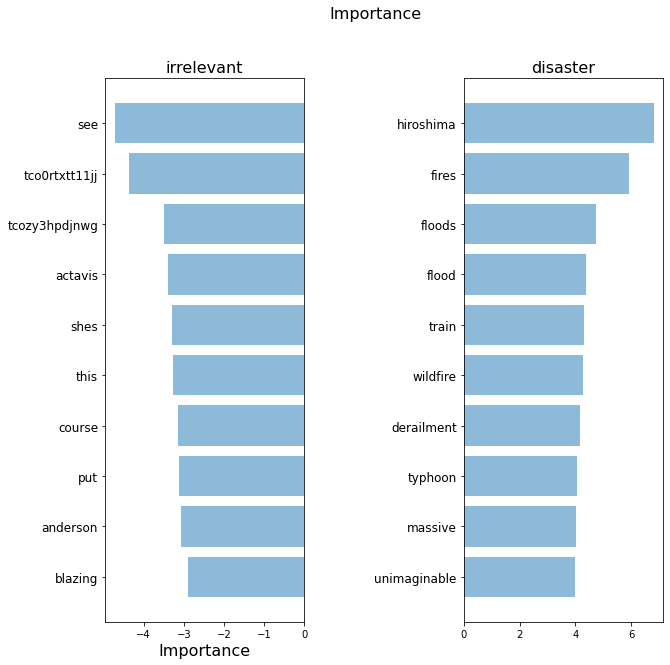

In [18]:
top_scores = [a[0] for a in importance[1]['tops']]
top_words = [a[1] for a in importance[1]['tops']]
bottom_scores = [a[0] for a in importance[1]['bottom']]
bottom_words = [a[1] for a in importance[1]['bottom']]
plot_important_words(
    top_scores,
    top_words,
    bottom_scores,
    bottom_words,
    'Most important words for relevance'
)